In [6]:
import sys
sys.path.append('/home/fenglab/Desktop/transdiff_GRN/src/')

from find_modules import *
from topology import *
from rank_centrality import *
from scipy.stats import fisher_exact
from scipy.stats import ranksums
from statsmodels.stats import multitest

random_s = 10
random.seed(random_s)

In [7]:
with open('./../../data/GSE208199/QuickGO-annotations-TFs-mus.tsv', 'r') as f:
    lines = f.readlines()
tfs = [line.split('\t')[2] for line in lines[1:]]

with open('./../../data/GSE208199/grn_expression_t3.txt', 'r') as f:
    lines = f.readlines()
genes = [line.split('\t')[0] for line in lines[1:]]

with open('./../../data/GSE208199/grn_expression_t5.txt', 'r') as f:
    lines = f.readlines()
genes2 = [line.split('\t')[0] for line in lines[1:]]

grntfs = list(set(tfs)&set(genes+genes2))

In [8]:
treatments = ['Ascl1p', 'Ascl1n', 'Ngn2p', 'Ngn2n']
colors = {'Ascl1p':'#24a394', 'Ascl1n':'#03574d', 'Ngn2p':'#b5971d', 'Ngn2n':'#705b06'}

In [9]:
def node_count_group(df):
    xt = [b for (a,b) in df.groupby(['run','nodes']).count().index]
    xt_plot = np.array(np.round(np.array(xt)/50)*50, dtype=int)

    # count non-TFs
    yntf = df[~df['geneid'].isin(grntfs)].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count total genes
    yt = df.groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count non-TFs with positive betweenness centrality
    yntfn = df[(~df['geneid'].isin(grntfs))&(df['betweenness_centrality']>0)].groupby(['run','nodes'])\
            .count()[['geneid']].to_numpy().flatten()
    # count genes with positive betweenness centrality
    yn = df[df['betweenness_centrality']>0].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()

    dfplt = pd.DataFrame([xt_plot,(yntf-yntfn)/yt*100,
                  (yt-yn-yntf+yntfn)/yt*100,
                  yntfn/yt*100,
                  (yn-yntfn)/yt*100], index=['plotnodes','nonTF0','TF0','nonTF','TF']).T
    dfplt = dfplt[dfplt['plotnodes']>0]

    bar = dfplt.groupby('plotnodes').mean()
    err = dfplt.groupby('plotnodes').std()
    return bar,err

In [10]:
def TF_btw_fisher_test(df):
    # count non-TFs
    yntf = df[~df['geneid'].isin(grntfs)].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count total genes
    yt = df.groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count non-TFs with positive betweenness centrality
    yntfn = df[(~df['geneid'].isin(grntfs))&(df['betweenness_centrality']>0)].groupby(['run','nodes'])\
            .count()[['geneid']].to_numpy().flatten()
    # count genes with positive betweenness centrality
    yn = df[df['betweenness_centrality']>0].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()

    dfct = pd.DataFrame([yt,(yntf-yntfn),
                  (yt-yn-yntf+yntfn),
                  yntfn,
                  (yn-yntfn)], index=['nodes','nonTF0','TF0','nonTF','TF']).T
    dfct = dfct[dfct['nodes']>50]
    
    rs=[]
    ps=[]
    for n in range(len(dfct)):
        (r,p) = fisher_exact(np.reshape(dfct.to_numpy()[n,1:],(2,2)), alternative='two-sided')
        rs.append(r)
        ps.append(p)
    dfct['Odds'] = rs
    dfct['p'] = ps
    return dfct

In [11]:
def TF_btw_wilcoxon_test(df):
    # non-TFs
    dfp1 = df[(~df['geneid'].isin(grntfs))][['run','nodes','betweenness_centrality']]
    dfp1 = dfp1[dfp1['nodes']>50]
    # TFs
    dfp2 = df[(df['geneid'].isin(grntfs))][['run','nodes','betweenness_centrality']]
    dfp2 = dfp2[dfp2['nodes']>50]
    
    xt = [(a,b) for (a,b) in dfp2.groupby(['run','nodes']).count().index]
    
    ss = []
    ps = []
    for (a,b) in xt:
        (s,p)=ranksums(dfp2[(dfp2['run']==a)&(dfp2['nodes']==b)]['betweenness_centrality'],
                        dfp1[(dfp1['run']==a)&(dfp1['nodes']==b)]['betweenness_centrality'])
        ss.append(s)
        ps.append(p)
    dfct = dfp2.groupby(['run','nodes']).count()
    dfct['stats'] = ss
    dfct['p'] = ps
    return dfct.drop(columns=['betweenness_centrality'])

In [36]:
df = pd.read_csv(f'./../../results/GSE208199/centrality_{treatments[0]}_t5.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

ValueError: operands could not be broadcast together with shapes (100,) (99,) 

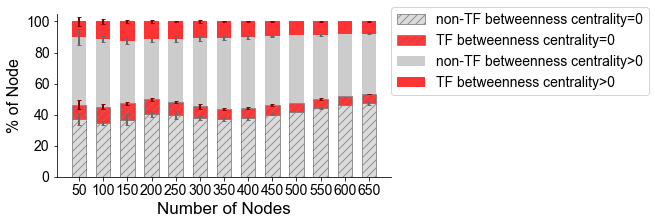

In [37]:
fig, ax = plt.subplots(figsize=(6, 3))
mpl.rcParams['hatch.linewidth']=1
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey',
      label='non-TF betweenness centrality=0')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',
       edgecolor='grey', label='TF betweenness centrality=0')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8,
      label='non-TF betweenness centrality>0')
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8,
      label='TF betweenness centrality>0')

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.legend(loc=(1,0.5),prop={'size':14})
plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2A1.svg', pad_inches=0.1, bbox_inches='tight')

    nodes  nonTF0  TF0  nonTF  TF      Odds         p
59    620     286   35    248  51  1.680415  0.027710
96    540     238   30    223  49  1.743199  0.028319


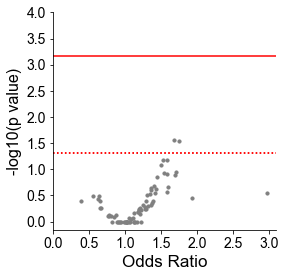

In [38]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2A2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

Empty DataFrame
Columns: [stats, p]
Index: []


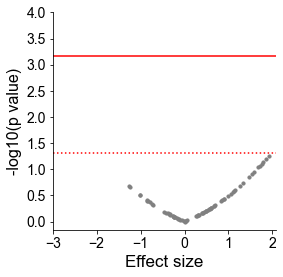

In [39]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=-3)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2A3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])

In [40]:
df = pd.read_csv(f'./../../results/GSE208199/centrality_{treatments[1]}_t5.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

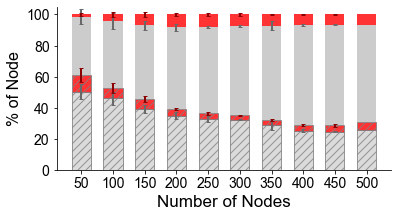

In [41]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2B1.svg', pad_inches=0.1, bbox_inches='tight')

    nodes  nonTF0  TF0  nonTF  TF      Odds         p
27    182      63    4     96  19  3.117188  0.040306
37    446     107   21    289  29  0.511287  0.031631
38    474     116   23    303  32  0.532645  0.039803
39    505     129   27    316  33  0.498945  0.016622
46     73      32    8     32   1  0.125000  0.035076
59    435     104   21    282  28  0.491726  0.028432


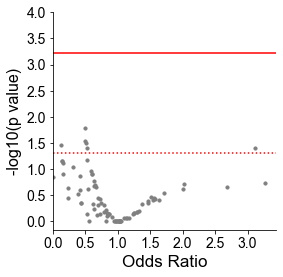

In [42]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2B2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

              stats         p
run nodes                    
2   405   -1.989547  0.046641
    446   -2.514534  0.011919
    474   -2.752619  0.005912
    505   -2.738297  0.006176
3   73    -1.979910  0.047714
    131   -2.385672  0.017048
    435   -2.419237  0.015553
4   435   -2.269576  0.023233


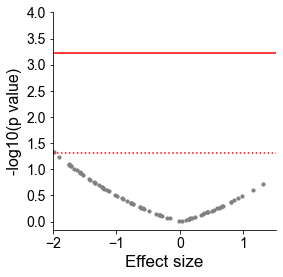

In [43]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=-2)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2B3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])

In [27]:
df = pd.read_csv(f'./../../results/GSE208199/centrality_{treatments[2]}_t5.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

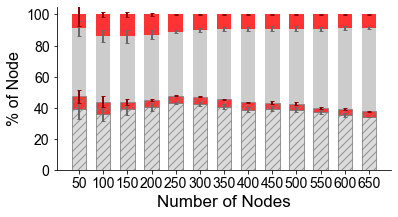

In [28]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2C1.svg', pad_inches=0.1, bbox_inches='tight')

    nodes  nonTF0  TF0  nonTF  TF      Odds         p
6     131      46    4     62  19  3.524194  0.032230
8     224      91   10     97  26  2.439175  0.027882
9     263     113   12    109  29  2.505352  0.011153
10    303     125   13    134  31  2.224455  0.022468
11    347     145   15    155  32  1.995699  0.040938
15    490     179   15    250  46  2.195733  0.011496
16    534     201   15    268  50  2.500000  0.002776
26    137      52    4     60  21  4.550000  0.006263
27    206      89   10     81  26  2.856790  0.009639
28    221      92    9     92  28  3.111111  0.006117
29    281     120   14    116  31  2.290640  0.021869
30    311     131   14    134  32  2.234542  0.024226
34    471     194   12    217  48  3.576037  0.000073
35    499     195   12    243  49  3.276749  0.000162
36    529     197   12    268  52  3.185323  0.000207
37    570     196   14    306  54  2.470588  0.003024
38    610     217   16    321  56  2.366044  0.002846
47    118      46    4     4

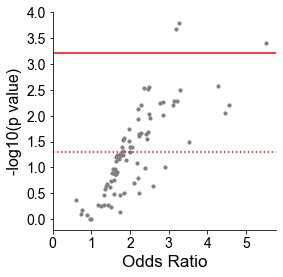

In [29]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2C2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

              stats         p
run nodes                    
1   191    2.087279  0.036863
    224    2.285039  0.022311
    263    2.792264  0.005234
    303    2.635366  0.008405
    347    2.502139  0.012345
...             ...       ...
5   454    2.873917  0.004054
    491    2.413270  0.015810
    536    3.180287  0.001471
    575    2.736501  0.006210
    612    2.607801  0.009113

[61 rows x 2 columns]


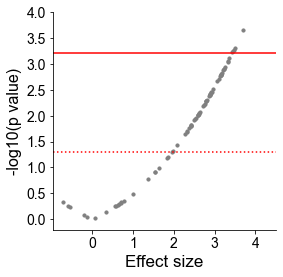

In [30]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim(left=-7)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2C3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])

In [32]:
df = pd.read_csv(f'./../../results/GSE208199/centrality_{treatments[3]}_t5.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

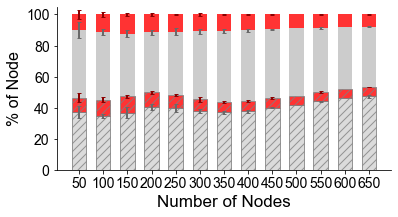

In [33]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2D1.svg', pad_inches=0.1, bbox_inches='tight')

    nodes  nonTF0  TF0  nonTF  TF      Odds         p
59    620     286   35    248  51  1.680415  0.027710
96    540     238   30    223  49  1.743199  0.028319


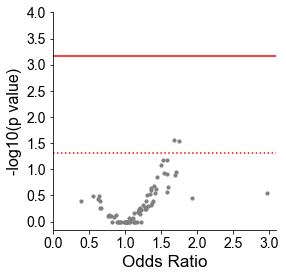

In [34]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2D2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

Empty DataFrame
Columns: [stats, p]
Index: []


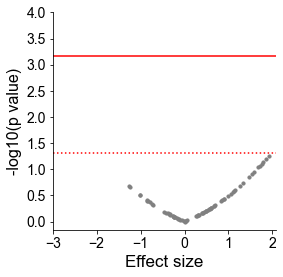

In [35]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=-3)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# plt.savefig('./../figs/S2D3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])